In [12]:
import findspark
findspark.init()

# SQLContext or HiveContext in Spark 1.x
from pyspark.sql import SparkSession
from pyspark import SparkContext

sc = SparkContext()

# rdd = sc.parallelize([("a", 1)])
# hasattr(rdd, "toDF")
# ## False

spark = SparkSession(sc)
# hasattr(rdd, "toDF")
# ## True

# rdd.toDF().show()

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at <ipython-input-1-ccf36d563afa>:8 

In [ ]:
from pyspark.sql.functions import udf
import pyspark.sql.functions as F
from pyspark.sql.types import *
import pandas as pd
import numpy as np

from pyspark.pyspark.mllib.linalg import Matrix, Matrices
from pyspark.mllib.linalg.distributed import BlockMatrix


In [ ]:
link_ids = spark.read.format("csv").option("inferSchema", "true") \
.option("header", "true") \
.option("delimiter", " ") \
.load(r"C:\Users\uschlac\Documents\Spark_Practice\Dataset\links.dat")

In [ ]:
link_ids.show()

In [ ]:
connenctions = spark.read.format("csv").option("inferSchema", "true") \
.option("header", "true") \
.option("delimiter", " ") \
.load(r"C:\Users\uschlac\Documents\Spark_Practice\Dataset\hollins.dat")

In [ ]:
# Authority Weights Vector:
# v = (A)t * u
# Assuming inital hub weight (u) is one.




# Sample Graph:

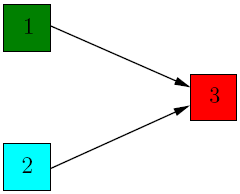

In [13]:
from IPython.display import Image
Image(filename=r'hits.png') 

### In the above image we have three individual web pages labeled (1, 2, and 3).

### From the initial view, we can see that Nodes: 1 and 2 are Hub Nodes (web pages that lead to others) and that Node: 3 is an Authority Node (Web Page that is the final destination).

### Matrix Structure

| Node Label | Ends at 1 | Ends at 2 | Ends at 3 |
| --- | --- | --- | --- |
| Starts at 1 | 0 | 0 | 1 |
| Starts at 2 | 0 | 0 | 1 |
| Starts at 3 | 0 | 0 | 0 |

### Adjacency  Matrix in Spark:

$$A = \begin{bmatrix} 0 & 0 & 1 \\ 0 & 0 & 1 \\ 0 & 0 & 0 \end{bmatrix}$$


### Authority Weight Calculation:

$$v = A^T \cdot u = \begin{bmatrix} 0 & 0 & 0 \\ 0 & 0 & 0 \\ 1 & 1 & 0 \end{bmatrix} \cdot \begin{bmatrix} 1 \\ 1 \\ 1 \end{bmatrix} = \begin{bmatrix} 0 \\ 2 \\ 2 \end{bmatrix} $$





### Hub Weight Calculation:
$$u = A \cdot v = \begin{bmatrix} 0 & 0 & 1 \\ 0 & 0 & 1 \\ 0 & 0 & 0 \end{bmatrix} \cdot \begin{bmatrix} 0 \\ 0 \\ 2 \end{bmatrix} = \begin{bmatrix} 2 \\ 2 \\ 0 \end{bmatrix} $$


## Implementation in Pyspark:

In [14]:
# Adjacency Matrix:
dm_1 = Matrices.dense(3, 3, [0,0,0,0,0,0,1,1,0])
blocks_1 = sc.parallelize([((0, 0), dm_1)])
mat_1 = BlockMatrix(blocks_1, 3, 3)

# Initial Hub Weights:
weights = Matrices.dense(3, 1, [1,1,1])
weight_block = sc.parallelize([((0, 0), weights)])
weight_block = BlockMatrix(weight_block, 3, 1)
print("Inital Hub Weights: " + "\n" + str(weight_block.toLocalMatrix()))

#Authority Blocks:
print("\n")
authority_weight = mat_1.transpose().multiply(weight_block)
print("Authority Weights: " + "\n" + str(authority_weight.toLocalMatrix()))
print("\n")

# Updated Hub Weights:
hub_weight = mat_1.multiply(authority_weight)
print("Updated Hub Weights: " + "\n" + str(hub_weight.toLocalMatrix()))

Inital Hub Weights: 
DenseMatrix([[1.],
             [1.],
             [1.]])


Authority Weights: 
DenseMatrix([[0.],
             [0.],
             [2.]])


Updated Hub Weights: 
DenseMatrix([[2.],
             [2.],
             [0.]])


## Dataset Implementation:

## The Dataset I am using for this Analysis is from Hollins University Website. This dataset contains information on the webmap of their website. This includes which webpages are linked to others.

## The Dataset can be found on my github or at this link.

In [ ]:
https://www.limfinity.com/ir/

In [15]:
b = connenctions.filter(connenctions.start.between(0,20) & connenctions.end.between(0,20))
b.show()
mat_sample = b.groupBy("start").pivot("end").agg(F.lit(1)).na.fill(0).sort(F.col("start").asc())
mat_sample.show()

+-----+---+
|start|end|
+-----+---+
|    1|  2|
|    8|  2|
|   16|  2|
|   18|  2|
|   20|  2|
|    1|  3|
|    1|  4|
|    1|  5|
|    1|  6|
|    1|  7|
|    4|  7|
|    5|  7|
|    8|  7|
|    9|  7|
|   11|  7|
|   13|  7|
|   15|  7|
|   19|  7|
|    1|  8|
|    1|  9|
+-----+---+
only showing top 20 rows

+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|start|  2|  3|  4|  5|  6|  7|  8|  9| 10| 11| 12| 13| 14| 15| 16| 17| 18| 19| 20|
+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|    1|  1|  1|  1|  1|  1|  1|  1|  1|  1|  1|  1|  1|  1|  1|  1|  1|  1|  1|  1|
|    4|  0|  0|  0|  0|  0|  1|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  1|  0|
|    5|  0|  0|  0|  0|  0|  1|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  1|  0|
|    7|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  1|  0|
|    8|  1|  0|  0|  0|  0|  1|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  1|  0|
|    9|  0|  0

In [16]:
row_count = mat_sample.select(mat_sample.columns[1:]).count()
print("Row Count: " + str(row_count))
col_count = len(mat_sample.select(mat_sample.columns[1:]).columns)
print("Column Count: " + str(col_count))

Row Count: 13
Column Count: 19


In [17]:
# Adjacency Matrix:
sample_matrix = Matrices.dense(row_count, col_count, np.array(mat_sample.select(mat_sample.columns[1:]).collect()).flatten())
sample_block = sc.parallelize([((0, 0), sample_matrix)])
sample_block_matrix = BlockMatrix(sample_block, row_count, col_count)

# Initial Hub Weight Vector:
weights = Matrices.dense(row_count, 1, np.repeat(1, row_count))
weight_block = sc.parallelize([((0, 0), weights)])
weight_block = BlockMatrix(weight_block, row_count, 1)

In [18]:
#Authority Blocks:
print(sample_block_matrix.transpose().multiply(weight_block).toLocalMatrix())

authority_weight = sample_block_matrix.transpose().multiply(weight_block)

DenseMatrix([[13.],
             [ 7.],
             [ 1.],
             [ 1.],
             [ 1.],
             [ 2.],
             [ 1.],
             [ 3.],
             [ 2.],
             [ 1.],
             [ 2.],
             [ 1.],
             [ 1.],
             [ 2.],
             [ 1.],
             [ 0.],
             [ 1.],
             [ 1.],
             [ 0.]])


In [19]:
# Hub Weights:
print(sample_block_matrix.multiply(authority_weight).toLocalMatrix())

hub_weight = sample_block_matrix.multiply(authority_weight)

DenseMatrix([[22.],
             [23.],
             [26.],
             [22.],
             [23.],
             [20.],
             [14.],
             [15.],
             [18.],
             [18.],
             [14.],
             [22.],
             [16.]])


In [20]:
spark.createDataFrame()

TypeError: createDataFrame() missing 1 required positional argument: 'data'

In [ ]:
hub_weight.rowsPerBlock

In [ ]:
connenctions.show()

In [ ]:
mat = connenctions.groupBy("start").pivot("end").agg(F.lit(1)).na.fill(0).sort(F.col("start").asc())